In [2]:
# Import data
import pandas as pd
df = pd.read_csv("AAPL01.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-02,0.314732,0.334821,0.312500,0.332589,0.265325,183198400
1,1990-01-03,0.339286,0.339286,0.334821,0.334821,0.267106,207995200
2,1990-01-04,0.341518,0.345982,0.332589,0.335938,0.267997,221513600
3,1990-01-05,0.337054,0.341518,0.330357,0.337054,0.268887,123312000
4,1990-01-08,0.334821,0.339286,0.330357,0.339286,0.270668,101572800


In [3]:

# Taking only the closing price and date coumn
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1990-01-02,0.332589
1,1990-01-03,0.334821
2,1990-01-04,0.335938
3,1990-01-05,0.337054
4,1990-01-08,0.339286


In [4]:
# Formetting date and index
import datetime

def datetime_str(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)
datetime_object = datetime_str('1990-01-02')

df['Date'] = df['Date'].apply(datetime_str)
df['Date']
df.index = df.pop('Date')
df.head()

,Close
Date,
1990-01-02,0.332589
1990-01-03,0.334821
1990-01-04,0.335938
1990-01-05,0.337054
1990-01-08,0.339286


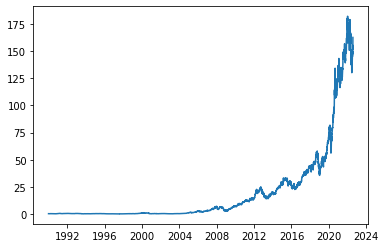

In [5]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [6]:
# This function will give us output on the based of the input. 
# Target 1, Target 2, Target 3 are the previous value respectively to the current date.
# Target is the predicted outut. 

import numpy as np

def windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = datetime_str(first_date_str)
  last_date  = datetime_str(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = windowed_df(df, 
                                '2020-01-01', 
                                '2022-07-29', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2020-01-01,72.477501,72.449997,72.879997,73.412498
1,2020-01-03,72.879997,73.412498,75.087502,74.357498
2,2020-01-06,73.412498,75.087502,74.357498,74.949997
3,2020-01-07,75.087502,74.357498,74.949997,74.597504
4,2020-01-08,74.357498,74.949997,74.597504,75.797501
...,...,...,...,...,...
644,2022-07-25,153.039993,155.350006,154.089996,152.949997
645,2022-07-26,155.350006,154.089996,152.949997,151.600006
646,2022-07-27,154.089996,152.949997,151.600006,156.789993
647,2022-07-28,152.949997,151.600006,156.789993,157.350006


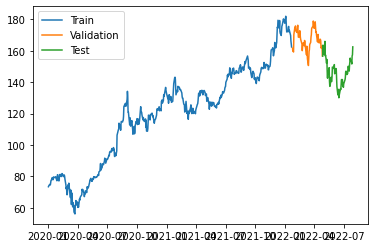

In [7]:
# Here this function will separate the data to train and validate the model
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape
D80 = int(len(dates) * .8) # 80% data to train the model
D90 = int(len(dates) * .9) # The next 10% data to validate the model

dates_train, X_train, y_train = dates[:D80], X[:D80], y[:D80]

dates_val, X_val, y_val = dates[D80:D90], X[D80:D90], y[D80:D90]
dates_test, X_test, y_test = dates[D90:], X[D90:], y[D90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [8]:
# Building our model by using the 'tensorflow' package.
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
17/17 [==============================] - 3s 49ms/step - loss: 15176.2900 - mean_absolute_error: 119.3937 - val_loss: 27763.8516 - val_mean_absolute_error: 166.4982
Epoch 2/100
17/17 [==============================] - 0s 7ms/step - loss: 14874.9297 - mean_absolute_error: 118.1319 - val_loss: 27153.1914 - val_mean_absolute_error: 164.6541
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 14236.0381 - mean_absolute_error: 115.3852 - val_loss: 25914.5000 - val_mean_absolute_error: 160.8486
Epoch 4/100
17/17 [==============================] - 0s 8ms/step - loss: 13037.8916 - mean_absolute_error: 109.9661 - val_loss: 23508.6797 - val_mean_absolute_error: 153.1861
Epoch 5/100
17/17 [==============================] - 0s 8ms/step - loss: 10517.6406 - mean_absolute_error: 97.6888 - val_loss: 18325.1621 - val_mean_absolute_error: 135.2101
Epoch 6/100
17/17 [==============================] - 0s 7ms/step - loss: 6368.4546 - mean_absolute_error: 73.0785 - val_loss:

17/17 [==============================] - 1s 3ms/step


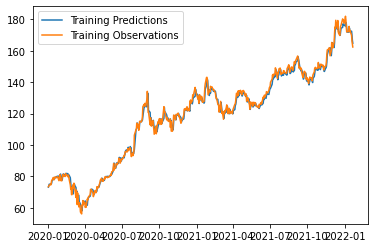

In [9]:
# Train the model. 
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])


3/3 [==============================] - 0s 6ms/step


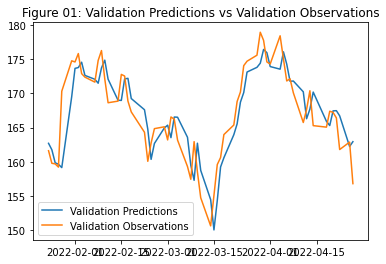

In [10]:
# Validate the model
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.title("Figure 01: Validation Predictions vs Validation Observations")
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 4ms/step


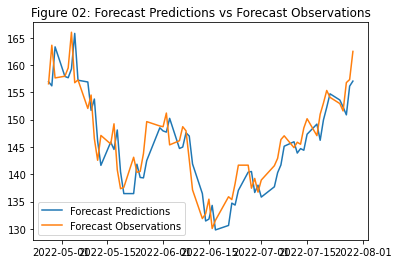

In [11]:
# forcast and compare
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title("Figure 02: Forecast Predictions vs Forecast Observations")
plt.legend(['Forecast Predictions', 'Forecast Observations'])